In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler

In [3]:
model = joblib.load('/content/drive/MyDrive/FYP_Models/model.joblib')
model_svm = joblib.load('/content/drive/MyDrive/FYP_Models/model_svm.joblib')

## RF prediction

In [4]:
def predict_with_RF(input_data):

    manual_encoding = {
    "Travel Group": {
        'Solo traveler': 0,
        'Traveling with friends': 3,
        'Traveling with partner': 1,
        'Traveling with young kids (under 12)': 5,
        'Traveling with teenagers (12-18)': 4,
        'Traveling with family (multi-generational)': 2
    },
    "Budget": {
        "Budget/Backpacking": 0,
        "Mid-range": 2,
        "Luxury": 1
    },
    "Accommodation": {
        "Hostels & guesthouses": 3,
        "Budget hotels & Airbnb": 2,
        "3 - 4 star hotels": 0,
        "5 - star hotels & luxury resorts": 1
    },
    "Activity Interest": {
        "Food tours & local cuisine experiences": 0,
        "Hiking & trekking": 1,
        "Historical & cultural sightseeing": 2,
        "Relaxation & spa retreats": 3,
        "Shopping & city exploration": 4,
        "Spiritual & religious visits": 5,
        "Surfing & water sports": 6,
        "Wildlife safaris": 7
    },
    "Physical Activity Level": {
        'Very active': 2,
        'Moderately active': 1,
        'Less active': 0
    },
    "Experience Level": {
        "First-time traveler": 0,
        "Have traveled occasionally": 2,
        "Frequent traveler": 1
    }
    }

    for column in input_data.columns:
        #if column in manual_encoding:
            input_data[column] = input_data[column].map(manual_encoding[column])
    # Generate prediction using the trained Random Forest model
    predicted_category_encoded = model.predict(input_data)

    # Decode the predicted category back to original words
    predicted_category =  predicted_category = (lambda x: [
        "Adventure & Unique Experiences",
        "Beaches & Coastal Areas",
        "Historical & Cultural Sites",
        "Nature & Wildlife",
    ][x[0]])(predicted_category_encoded)

    return predicted_category

## SVM prediction

In [5]:
# Define mappings and constants
MONTH_MAP = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
             "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

ACTIVITY_COMPATIBILITY = {
    'Hiking & trekking': ['Hiking', 'Trekking', 'Climbing'],
    'Surfing & water sports': ['Surfing', 'Swimming', 'Snorkeling', 'Whale Watching', 'Boating', 'Rafting'],
    'Wildlife safaris': ['Safari'],
    'Historical & cultural sightseeing': ['Sightseeing', 'Temple Visit'],
    'Relaxation & spa retreats': ['Relaxation'],
    'Spiritual & religious visits': ['Temple Visit'],
    'Food tours & local cuisine experiences': [],
    'Shopping & city exploration': []
}

PHYSICAL_ACTIVITY_MAP = {
    'Sightseeing': 1, 'Hiking': 3, 'Relaxation': 1, 'Rafting': 3, 'Boating': 2,
    'Climbing': 3, 'Safari': 2, 'Trekking': 3, 'Surfing': 2, 'Swimming': 2,
    'Snorkeling': 2, 'Whale Watching': 1, 'Temple Visit': 1
}

USER_BUDGET_MAP = {
    "Budget/Backpacking": "Low",
    "Mid-range": "Medium",
    "Luxury": "High"
}

# Define feature lists
CATEGORIES = ["Adventure & Unique Experiences", "Historical & Cultural Sites",
              "Nature & Wildlife", "Beaches & Coastal Areas"]
ACTIVITIES = ["Sightseeing", "Hiking", "Relaxation", "Rafting", "Boating", "Climbing",
              "Safari", "Trekking", "Surfing", "Swimming", "Snorkeling", "Whale Watching", "Temple Visit"]
BUDGET_LEVELS = ["Low", "Medium", "High"]
AGE_GROUPS = ["18-30 years", "31-50 years", "51+ years"]
GENDERS = ["Male", "Female"]
TRAVEL_GROUPS = ["Traveling with teenagers (12-18)", "Traveling with friends", "Traveling with extended family (multi-generational)", "Traveling with young kids (under 12)", "Traveling with a partner", "Solo traveler"]
ACCOMMODATIONS = ["3 - 4 star hotels", "Budget hotels & Airbnb", "5 - star hotels & luxury resorts", "Hostels & guesthouses"]
TRAVELER_TYPES = ["Food & culinary explorer", "Nature & wildlife lover", "Adventure seeker",
                  "History & culture enthusiast", "Beach & relaxation seeker"]
PHYSICAL_LEVELS = ["Less active", "Moderately active", "Very active"]
SPECIAL_NEEDS = ["Yes", "No"]
EXPERIENCE_LEVELS = ["First-time traveler", "Have traveled occasionally", "Frequent traveler"]

dataset_path = "/content/drive/MyDrive/FYP_Datasets/dataset_80k.csv"
# Simulated data (replace with actual CSV loading)
SYNTHETIC_DATA = pd.read_csv(dataset_path)

DESTINATION_DATA = pd.read_csv("/content/drive/MyDrive/FYP_Datasets/attribute_data_destinations.csv")

# Create destination-to-category mapping
dest_to_category = SYNTHETIC_DATA.groupby('Sample Destination')['Preferred Destination Category'].first().to_dict()

scaling_df = pd.DataFrame()


In [6]:
def predict_with_SVM(input_data):
    global scaling_df # Declare scaling_df as a global variable

    manual_encoding = {
      "Age Group": {
        "18-30 years": 0,
        "31-50 years": 1,
        "51+ years": 2
      },
      "Gender": {
        "Female": 0,
        "Male": 1
      },
      "Country": {
        "Australia/New Zealand": 0,
        "East Asia (China, Japan, Korea, etc.)": 1,
        "Europe": 2,
        "India": 3,
        "Middle East": 4,
        "Sri Lanka": 5,
        "USA/Canada": 6
      }
    }

    for column in input_data.columns:
        #if column in manual_encoding:
            input_data[column] = input_data[column].map(manual_encoding[column])

    scaler = StandardScaler()

    if(scaling_df.empty):
      scl_df = pd.read_csv(dataset_path)
      scl_df = scl_df.dropna()
      scl_df = scl_df[['Age Group', 'Gender', 'Country']]
      scl_df = scl_df.sample(n= 64000, random_state=42)
      for column in scl_df.columns:
        #if column in manual_encoding:
            scl_df[column] = scl_df[column].map(manual_encoding[column])
      scaling_df = scl_df

    scaler.fit_transform(scaling_df)
    #scaler = joblib.load('/content/drive/MyDrive/FYP_Models/scaler_svm.joblib')
    # Standardize numerical features in sample data
    sample_input_scaled = scaler.transform(input_data) # Use the scaler fitted on the training data
    # Generate prediction using the trained SVM model
    predicted_category_encoded = model_svm.predict(sample_input_scaled)

    predicted_category =  predicted_category = (lambda x: [
        "Adventure & Unique Experiences",
        "Beaches & Coastal Areas",
        "Historical & Cultural Sites",
        "Nature & Wildlife",
    ][x[0]])(predicted_category_encoded)

    return predicted_category

In [7]:
def create_user_vector(user):
    # Season vector (12 months)
    if user['Travel Season'] == "Anytime":
        season_vec = [1] * 12
    elif user['Travel Season'] == "May to September":
        season_vec = [1 if m in [5, 6, 7, 8, 9] else 0 for m in range(1, 13)]
    elif user['Travel Season'] == "December to April":
        season_vec = [1 if m in [12, 1, 2, 3, 4] else 0 for m in range(1, 13)]
    else:
        season_vec = [0] * 12

    # Budget vector
    user_budget = USER_BUDGET_MAP.get(user['Budget'], "Medium")
    budget_vec = [1 if b == user_budget else 0 for b in BUDGET_LEVELS]

    # Category vector
    category_vec = [1 if c == '' else 0 for c in CATEGORIES]

    # Activity vector
    compatible_acts = ACTIVITY_COMPATIBILITY.get(user['Activity Interest'], [])
    activity_vec = [1 if a in compatible_acts else 0 for a in ACTIVITIES]

    # Age Group vector
    age_vec = [1 if a == user['Age Group'] else 0 for a in AGE_GROUPS]

    # Gender vector
    gender_vec = [1 if g == user['Gender'] else 0 for g in GENDERS]

    # Travel Group vector
    travel_group_vec = [1 if t == user['Travel Group'] else 0 for t in TRAVEL_GROUPS]

    # Accommodation vector
    accom_vec = [1 if a == user['Accommodation'] else 0 for a in ACCOMMODATIONS]

    # Traveler Type vector (no direct match, included as is)
    traveler_vec = [1 if t == user['Traveler Type'] else 0 for t in TRAVELER_TYPES]

    # Physical Activity Level vector
    phys_map = {"Less active": 1, "Moderately active": 2, "Very active": 3}
    user_phys = phys_map[user['Physical Activity Level']]
    phys_vec = [1 if i + 1 == user_phys else 0 for i in range(3)]

    # Special Needs vector
    special_vec = [1 if s == user['Special Needs'] else 0 for s in SPECIAL_NEEDS]

    # Experience Level vector
    exp_vec = [1 if e == user['Experience Level'] else 0 for e in EXPERIENCE_LEVELS]

    # Combine all vectors (Country is excluded as it doesn't match destinations)
    return np.array(season_vec + budget_vec + activity_vec + category_vec +
                    age_vec + gender_vec + travel_group_vec + accom_vec +
                    traveler_vec + phys_vec + special_vec + exp_vec)

In [8]:
def create_dest_vector(dest, category):
    # Season vector
    month_num = MONTH_MAP.get(dest['Best_Season'], 1)
    season_vec = [1 if m == month_num else 0 for m in range(1, 13)]

    # Budget vector
    budget_vec = [1 if b == dest['Budget_Level'] else 0 for b in BUDGET_LEVELS]

    # Category vector
    category_vec = [1 if c == category else 0 for c in CATEGORIES]

    # Activity vector
    activity_vec = [1 if a == dest['Main_Activity'] else 0 for a in ACTIVITIES]

    # Age Group (not directly available, assume all destinations suit all ages)
    age_vec = [1] * len(AGE_GROUPS)

    # Gender (assume all destinations suit all genders)
    gender_vec = [1] * len(GENDERS)

    # Travel Group (mapped from Suitable_For)
    travel_group_vec = [1 if t == dest['Suitable_For'] else 0 for t in TRAVEL_GROUPS]

    # Accommodation (inferred from Budget_Level)
    budget_to_accom = {"Low": "Budget Hotel/Hostel", "Medium": "Mid-range Hotel", "High": "Luxury Hotel/Resort"}
    dest_accom = budget_to_accom.get(dest['Budget_Level'], "Mid-range Hotel")
    accom_vec = [1 if a == dest_accom else 0 for a in ACCOMMODATIONS]

    # Traveler Type (no direct match, assume neutral)
    traveler_vec = [0] * len(TRAVELER_TYPES)

    # Physical Activity Level (inferred from Main_Activity)
    phys_level = PHYSICAL_ACTIVITY_MAP.get(dest['Main_Activity'], 2)
    phys_vec = [1 if i + 1 == phys_level else 0 for i in range(3)]

    # Special Needs (mapped from Accessibility)
    access_to_needs = {"High": "No", "Moderate": "No", "Low": "Yes"}
    special_vec = [1 if s == access_to_needs.get(dest['Accessibility'], "No") else 0 for s in SPECIAL_NEEDS]

    # Experience Level (not directly available, assume Intermediate)
    exp_vec = [1 if e == "Intermediate" else 0 for e in EXPERIENCE_LEVELS]

    return np.array(season_vec + budget_vec + category_vec + activity_vec +
                    age_vec + gender_vec + travel_group_vec + accom_vec +
                    traveler_vec + phys_vec + special_vec + exp_vec)

def cosine_sim(u, d):
    return np.dot(u, d) / (np.linalg.norm(u) * np.linalg.norm(d))

In [78]:
def get_recommended_destinations(input_data, rf_prediction, svm_prediction):
    # Select a user (e.g., first row)
    if isinstance(input_data, pd.DataFrame):
        user = input_data.iloc[0].to_dict()
    else:
        user = input_data.to_dict()
    #print("User data:", user)
    user_vec = create_user_vector(user)

    # Compute similarities for all destinations
    similarities = []
    dest_vectors = []
    for _, dest in DESTINATION_DATA.iterrows():
        dest_dict = dest.to_dict()
        category = dest_to_category.get(dest_dict['Destination'], "")
        if not category:
            continue
        dest_vec = create_dest_vector(dest_dict, category)
        dest_vectors.append(dest_vec)
        sim = cosine_sim(user_vec, dest_vec)
        similarities.append((dest_dict['Destination'], sim))

    if rf_prediction == "Beaches & Coastal Areas":
        similarities.sort(key=lambda x: x[1], reverse=True)
        return {"recommended_destinations": similarities[:10], "top_category": rf_prediction}
    if rf_prediction == "Historical & Cultural Sites":
        similarities.sort(key=lambda x: x[1], reverse=True)
        return {"recommended_destinations": similarities[:10], "top_category": rf_prediction}
    if svm_prediction == "Adventure & Unique Experiences":
        similarities.sort(key=lambda x: x[1], reverse=True)
        return {"recommended_destinations": similarities[:10], "top_category": svm_prediction}
    """
    if rf_prediction == svm_prediction:
        recommended_category = rf_prediction
        recommended_destinations = []
        for dest_name, score in similarities:
            category = dest_to_category.get(dest_name, "")
            if category == recommended_category:
                score += 0.1
            recommended_destinations.append((dest_name, score))
        similarities = recommended_destinations
    """
    recommended_destinations = []
    for dest_name, score in similarities:
            category = dest_to_category.get(dest_name, "")
            if category == rf_prediction:
                score += 0.2
            elif category == svm_prediction:
                score += 0.1
            recommended_destinations.append((dest_name, score))
    similarities = recommended_destinations
    # Sort and display top 5
    similarities.sort(key=lambda x: x[1], reverse=True)
    #print("Top 10 recommended destinations:")
    # Get top 3 destinations and their categories
    top_3 = similarities[:3]
    top_3_categories = [dest_to_category.get(dest_name, "") for dest_name, _ in top_3]
    # Get majority category
    if top_3_categories:
        #print(top_3_categories)
        top_category = max(set(top_3_categories), key=top_3_categories.count)
    else:
        top_category = rf_prediction
    return {"recommended_destinations": similarities[:10], "top_category": top_category}

## Measure Accuracy

In [80]:
def top_category_accuracy():
    # Load your dataset
    test_data = pd.read_csv(dataset_path)
    test_data = test_data.dropna()
    test_data = test_data.sample(n=10000, random_state=42)
    true_labels = test_data['Preferred Destination Category'].tolist()
    predicted_top_categories_rf = []
    predicted_top_categories_svm = []
    predicted_top_categories_hybrid = []

    for idx, row in test_data.iterrows():
        user_input = row.to_dict()
        # Prepare input for RF and SVM as in your predict endpoint
        input_df = pd.DataFrame([user_input])
        input_RF = input_df.drop(columns=['Age Group','Gender','Country', 'Traveler Type', 'Special Needs', 'Travel Season','Preferred Destination Category','Sample Destination','Unnamed: 0'], errors='ignore')
        input_SVM = input_df.drop(columns=['Travel Group', 'Budget', 'Accommodation', 'Traveler Type', 'Activity Interest', 'Physical Activity Level', 'Experience Level','Special Needs', 'Travel Season','Preferred Destination Category','Sample Destination','Unnamed: 0'], errors='ignore')
        rf_pred = predict_with_RF(input_RF)
        predicted_top_categories_rf.append(rf_pred)
        svm_pred = predict_with_SVM(input_SVM)
        predicted_top_categories_svm.append(svm_pred)
        recommended = get_recommended_destinations(input_df, rf_pred, svm_pred)
        predicted_top_categories_hybrid.append(recommended["top_category"])

    print("RF model results......")
    acc = accuracy_score(true_labels, predicted_top_categories_rf)
    print(f"Top Category Accuracy: {acc * 100:.2f}%")

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(true_labels, predicted_top_categories_rf), annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix RF")

    plt.show()

    print("SVM model results......")
    acc = accuracy_score(true_labels, predicted_top_categories_svm)
    print(f"Top Category Accuracy: {acc * 100:.2f}%")

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(true_labels, predicted_top_categories_svm), annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix SVM")
    plt.show()

    print("Hybrid model results......")
    acc = accuracy_score(true_labels, predicted_top_categories_hybrid)
    print(f"Top Category Accuracy: {acc * 100:.2f}%")

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(true_labels, predicted_top_categories_hybrid), annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

RF model results......
Top Category Accuracy: 57.12%


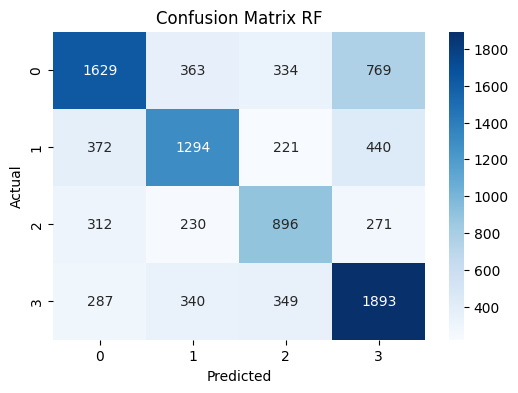

SVM model results......
Top Category Accuracy: 49.79%


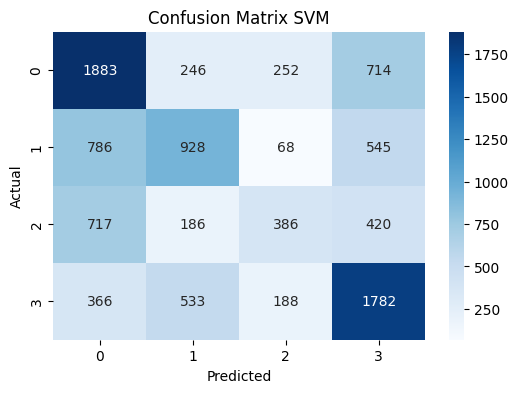

Hybrid model results......
Top Category Accuracy: 58.59%


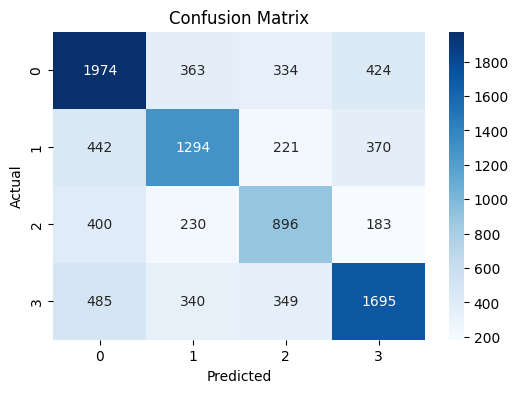

In [81]:
top_category_accuracy()